In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


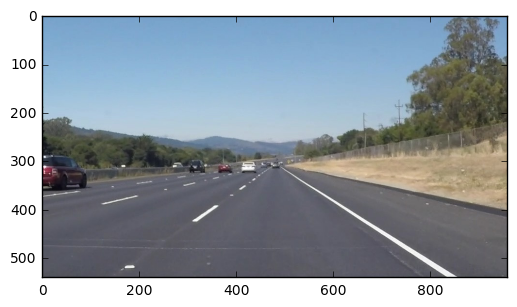

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [23]:
import math

def buffering(slope_buff,intercept_buff,ind,if_buff_full,m,c):
    slope_buff[ind] = m
    intercept_buff[ind] = c
    ind = ind + 1
    if ind == 10:
        if_buff_full = 1
        ind = 0
    
    return (slope_buff,intercept_buff,ind,if_buff_full)
    
    
    
    
# was a try to use linear kalman filter, doesn't provide good results without process noise matrix
def covariance_matrix(x,RSS,weights):
    # RSS is residual sum of squares
    x = np.array(x)
    X = np.vstack(( np.ones( x.size ),x ))
    X = np.matrix(X)
    W = np.diag(weights) # weights used for linear regression in polyfit
    C = np.linalg.inv( X * W * X.T )
    #C = np.linalg.inv( X * X.T )
    C = C*(RSS[0]/len(x)) # final covariance matrix of the line coefficents
    return C
    
    
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[0, 255, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    x_right_lane_values = []
    y_right_lane_values = []
    x_left_lane_values  = []
    y_left_lane_values  = []
    right_length = []
    left_length  = []
    y_bottom = 540
    y_top = 320
    m=(lines[:,0,3]-lines[:,0,1])/(lines[:,0,2]-lines[:,0,0])
   
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            
            if (m < -0.5 and m > -0.8): #left lane
                x_left_lane_values.append(x1)
                x_left_lane_values.append(x2)
                y_left_lane_values.append(y1)
                y_left_lane_values.append(y2)
                left_length.append(math.hypot(x2 - x1, y2 - y1)) #lengths of the line
                left_length.append(math.hypot(x2 - x1, y2 - y1))
            elif (m > 0.5 and m < 0.8):
                x_right_lane_values.append(x1)
                x_right_lane_values.append(x2)
                y_right_lane_values.append(y1)
                y_right_lane_values.append(y2)
                right_length.append(math.hypot(x2 - x1, y2 - y1))
                right_length.append(math.hypot(x2 - x1, y2 - y1))
    
    
    
    
   
    global m_left_buffer
    global c_left_buffer
    global left_buff_index
    global left_buff_full
    
    if x_left_lane_values:
        weights_left_lane = left_length/np.sum(left_length) # weighted linear regression, longer line points get more weightage
        c_left_W, stats = np.polynomial.polynomial.polyfit(x_left_lane_values,y_left_lane_values,1,full = True, w=weights_left_lane)
        (slope,intercept,ind,full_or_not)=buffering(m_left_buffer,c_left_buffer,left_buff_index,left_buff_full,c_left_W[1],c_left_W[0])
        m_left_buffer = slope
        c_left_buffer = intercept
        left_buff_index = ind
        left_buff_full = full_or_not         
            
                                 
        
    
    if left_buff_full == 1:
        cc = np.mean(c_left_buffer)
        mm = np.mean(m_left_buffer)
    elif left_buff_index!=0:        
        cc = np.sum(c_left_buffer[0:left_buff_index])/left_buff_index
        mm = np.sum(m_left_buffer[0:left_buff_index])/left_buff_index
       
    x_bottom_left  = int((y_bottom - cc)/mm)
    x_top_left     = int((y_top - cc)/mm)
    
    
    
   
    cv2.line(img,(x_bottom_left,y_bottom),(x_top_left ,y_top),color,thickness) # end of left lane processing
        
    
    global m_right_buffer
    global c_right_buffer
    global right_buff_index
    global right_buff_full
    
    if x_right_lane_values:        
        weights_right_lane = right_length/np.sum(right_length)
        c_right_W, stats = np.polynomial.polynomial.polyfit(x_right_lane_values,y_right_lane_values,1,full = True, w=weights_right_lane)
        (slope,intercept,ind,full_or_not)=buffering(m_right_buffer,c_right_buffer,right_buff_index,right_buff_full,c_right_W[1],c_right_W[0])
        m_right_buffer = slope
        c_right_buffer = intercept
        right_buff_index = ind
        right_buff_full = full_or_not   
            
            
                                 
        
    
    if right_buff_full == 1:
        cc = np.mean(c_right_buffer)
        mm = np.mean(m_right_buffer)
    elif right_buff_index!=0:       
        cc = np.sum(c_right_buffer[0:right_buff_index])/right_buff_index
        mm = np.sum(m_right_buffer[0:right_buff_index])/right_buff_index
      
    x_bottom_right  = int((y_bottom - cc)/mm)
    x_top_right     = int((y_top - cc)/mm)
    
    
    
   
    cv2.line(img,(x_bottom_right,y_bottom),(x_top_right ,y_top),color,thickness) # end of right lane processing
    
    
    
    
    
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [5]:
def read_image(image_path):
    return mpimg.imread(image_path)

In [6]:
# Read in the test images
test_images = [read_image('test_images/' + i) for i in os.listdir('test_images/')]

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
# Main()
def lane_markings(image):
    
    # Gray sacale image
    gray_image = grayscale(image)    
         
    # Adding gaussian blur
    blurred_gray_image = gaussian_blur(gray_image,5)
        
    # Canny edges
    edges_image = canny(blurred_gray_image, 50, 150)
        
    # Cropping the relevant region
    vertices = np.array([[(0,image.shape[0]),(470, 320), (490, 320), (image.shape[1],image.shape[0])]], dtype=np.int32)
    masked_edge_image = region_of_interest(edges_image, vertices)
        
    # Apllying Hough transform
    rho = 2 
    theta = np.pi/180 
    threshold = 45     
    min_line_len = 40 
    max_line_gap = 100    
    lines_image = hough_lines(masked_edge_image, rho, theta, threshold, min_line_len, max_line_gap)
        
    # Super imposing the images
    final_image = weighted_img(lines_image, image)
    
    plt.imshow(final_image)
    return final_image
        
    
    


In [10]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = lane_markings(image)
    return result

Processed solidWhiteCurve.jpg
Processed solidWhiteRight.jpg
Processed solidYellowCurve.jpg
Processed solidYellowCurve2.jpg
Processed solidYellowLeft.jpg
Processed whiteCarLaneSwitch.jpg
Annotation completed


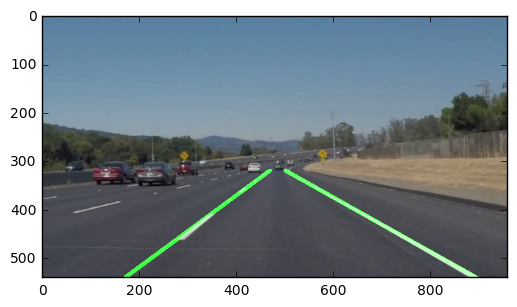

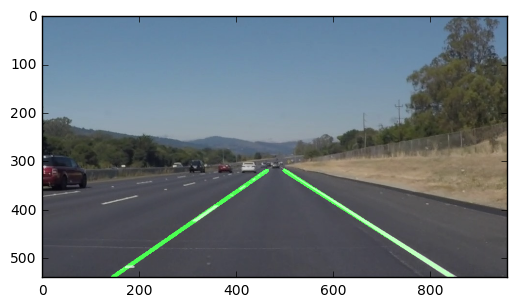

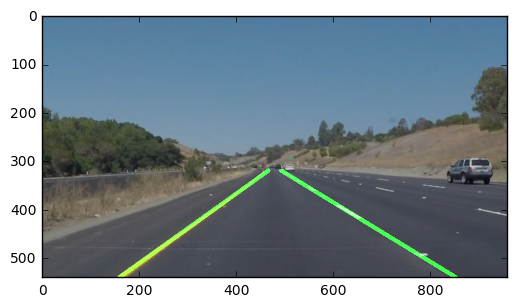

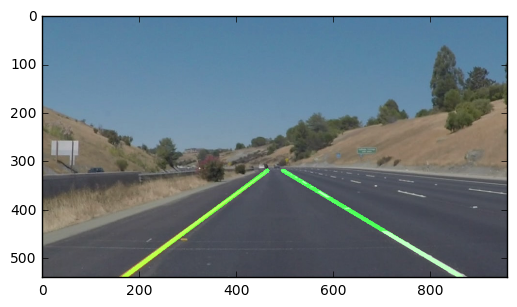

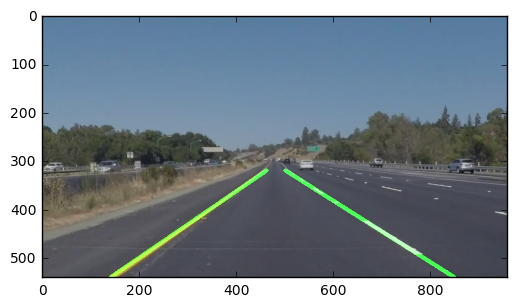

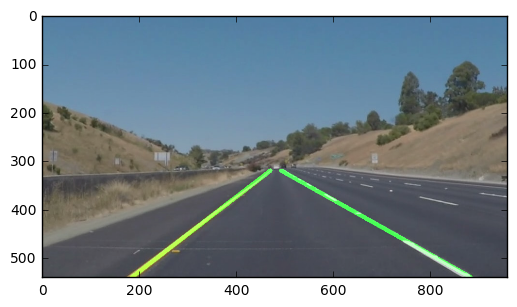

In [20]:
output_folder =  "test_images_out"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
for i in os.listdir('test_images/'):
    input_image = read_image('test_images/' + i)
    global m_left_buffer
    global c_left_buffer
    global left_buff_index
    global left_buff_full 
    left_buff_full = 0
    left_buff_index=0
    m_left_buffer=np.zeros(10)
    c_left_buffer = np.zeros(10)
    global m_right_buffer
    global c_right_buffer
    global right_buff_index
    global right_buff_full 
    right_buff_full = 0
    right_buff_index=0
    m_right_buffer=np.zeros(10)
    c_right_buffer = np.zeros(10)
    output_image = process_image(input_image)
    plt.imshow(output_image)
    plt.figure()
    mpimg.imsave(output_folder + "/" + i, output_image)
    print("Processed " + i)
print("Annotation completed")

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:11<00:00, 19.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 12.8 s


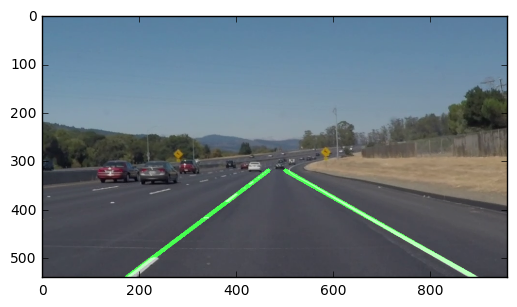

In [21]:
global m_left_buffer
global c_left_buffer
global left_buff_index
global left_buff_full 
left_buff_full = 0
left_buff_index=0
m_left_buffer=np.zeros(10)
c_left_buffer = np.zeros(10)
global m_right_buffer
global c_right_buffer
global right_buff_index
global right_buff_full 
right_buff_full = 0
right_buff_index=0
m_right_buffer=np.zeros(10)
c_right_buffer = np.zeros(10)
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:32<00:00, 20.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 34 s


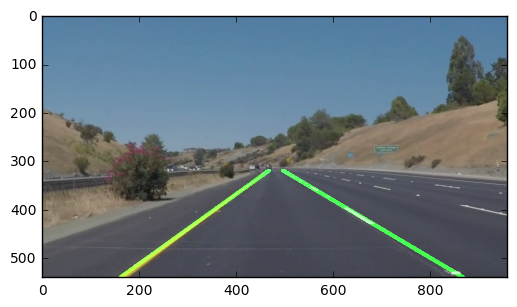

In [22]:
global m_left_buffer
global c_left_buffer
global left_buff_index
global left_buff_full 
left_buff_full = 0
left_buff_index=0
m_left_buffer=np.zeros(10)
c_left_buffer = np.zeros(10)
global m_right_buffer
global c_right_buffer
global right_buff_index
global right_buff_full 
right_buff_full = 0
right_buff_index=0
m_right_buffer=np.zeros(10)
c_right_buffer = np.zeros(10)
white_output = 'yellow.mp4'
clip1 = VideoFileClip("solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)